In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import cv2
image = cv2.imread('/content/gdrive/MyDrive/OpenMedical/Data/Example_Dataset/jpg/Axial/a(1).jpg')

In [ ]:
import numpy
unique, counts = numpy.unique(image, return_counts=True)
dict(zip(unique, counts))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models, datasets

from PIL import ImageFile, Image
from torch.utils.data import Dataset, DataLoader
import cv2

In [ ]:
!pip install pydicom
!pip install pypng

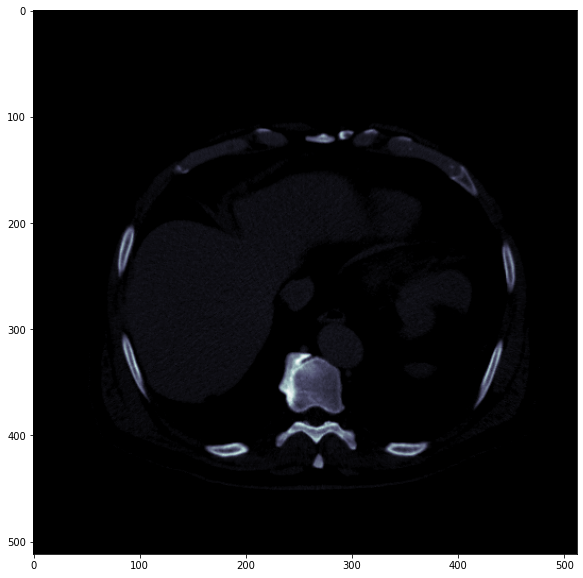

In [ ]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
from pydicom.pixel_data_handlers.util import apply_color_lut

filename = '/content/gdrive/MyDrive/OpenMedical/Data/Example_Dataset/jpg/Axial/1-001.dcm'
ds = pydicom.dcmread(filename)
arr = ds.pixel_array

## Step 1. Convert to float to avoid overflow or underflow losses.
img_2d = arr.astype(float)

## Step 2. Rescaling grey scale between 0-255
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0

## Step 3. Convert to uint
img_2d_scaled = np.uint8(img_2d_scaled)

f = plt.figure()

plt.imshow(img_2d_scaled, cmap=plt.cm.bone)

f.set_figwidth(10)
f.set_figheight(10)

In [ ]:
def convert_dcm_jpg(file):

    im = pydicom.dcmread(file)

    im = im.pixel_array.astype(float)

    rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
    final_image = np.uint8(rescaled_image) # integers pixels

    final_image = Image.fromarray(final_image)

    return final_image

In [ ]:
file = '/content/gdrive/MyDrive/OpenMedical/Data/Example_Dataset/dcm/Axial/1-001.dcm'

image = convert_dcm_jpg(file)
image.save('test.jpg')


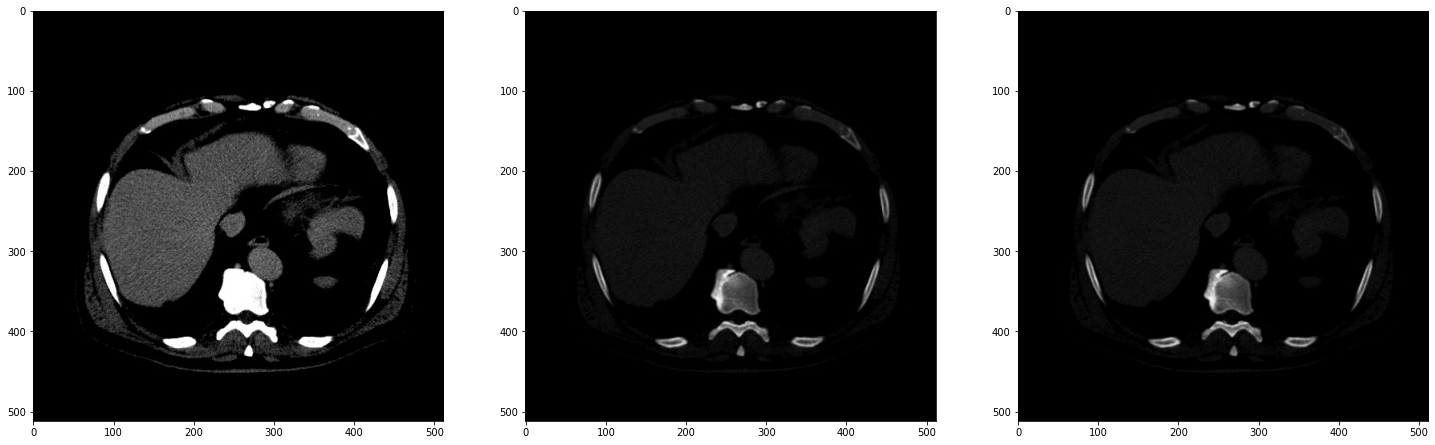

In [ ]:
import cv2

f, axarr = plt.subplots(1,3)

image = cv2.imread('/content/test.png')
axarr[2].imshow(image)

image = cv2.imread('/content/test.jpg')
axarr[1].imshow(image)

image = cv2.imread('/content/gdrive/MyDrive/OpenMedical/Data/Example_Dataset/jpg/Axial/a (1).jpg')
axarr[0].imshow(image)

f.set_figheight(25)
f.set_figwidth(25)

In [ ]:
import pydicom as dicom
import os
import cv2
import PIL # optional
# make it True if you want in PNG format
PNG = False
# Specify the .dcm folder path
folder_path = "/content/gdrive/MyDrive/OpenMedical/Data/Series Identification/Sample Images/11-26-2003-NA-NA-04845/5.000000-CESagittal3.0SagittalCONTRASTETARDIOSagittal-30483"
# Specify the output jpg/png folder path
jpg_folder_path = "/content/gdrive/MyDrive/OpenMedical/Data/Example_Dataset/jpg2/Sagittal"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

0 image converted
50 image converted
100 image converted


In [ ]:
classes = ('A', 'C', 'S')

def get_data_loader(batch_size):

  transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

  images_dataset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/EOpenMedical/Data/Example_Dataset/jpg', transform=transform)
  dataloader = DataLoader(images_dataset, batch_size=1, shuffle=True)

  indices = []
  for i in range(len(images_dataset)):
          label_index = images_dataset[i][1]
          label_class = classes[label_index]
          indices.append(i)

  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  np.random.shuffle(indices)
  split = int(len(indices) * 0.6)
  split2 = int(len(indices) * 0.8)

  relevant_train_indices, relevant_val_indices, relevant_test_indices = indices[:split], indices[split:split2] , indices[split2:]

  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)

  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)

  return train_loader, val_loader, test_loader

In [ ]:
batch_size = 16
train_loader, val_loader, test_loader = get_data_loader(batch_size=batch_size)

In [ ]:
print(len(train_loader.dataset)+len(val_loader.dataset))

718


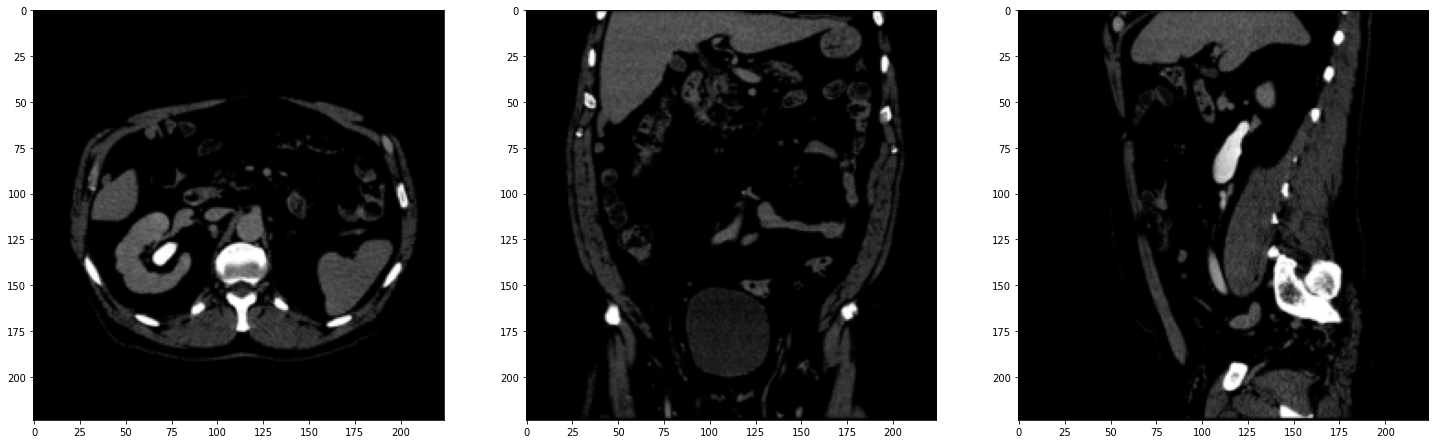

In [ ]:
condition_0 = False
condition_1 = False
condition_2 = False

for image, label in train_loader:
  for i in range(16):
    if label[i] == 0:
      image0 = image[i]
      condition_0 = True
    if label[i] == 1:
      image1 = image[i]
      condition_1 = True
    if label[i] == 2:
      image2 = image[i]
      condition_2 = True

    if condition_0 and condition_1 and condition_2:
      break

image0 = image0.transpose(0, 2).transpose(0,1)
image1 = image1.transpose(0, 2).transpose(0,1)
image2 = image2.transpose(0, 2).transpose(0,1)

f, axarr = plt.subplots(1,3)
f.set_figheight(25)
f.set_figwidth(25)
axarr[0].imshow(image0)
axarr[1].imshow(image1)
axarr[2].imshow(image2)

In [ ]:
class Classifier(nn.Module):
      def __init__(self):
          super(Classifier, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(53*53*10, 14045)
          self.fc2 = nn.Linear(14045, 10)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 53*53*10)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:



        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(data):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Finished Training
Total time elapsed: 565.26 seconds


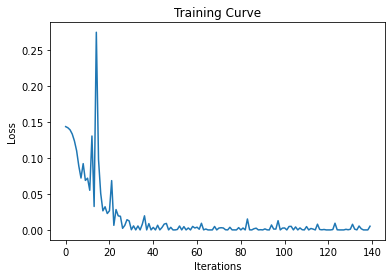

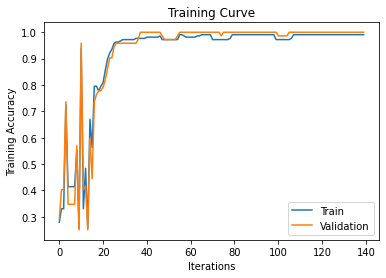

Final Training Accuracy: 0.9906976744186047
Final Validation Accuracy: 1.0


In [ ]:
model = Classifier()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_loader, num_epochs=10)

In [ ]:
classes = ('A', 'C', 'S')

def get_data_loader(batch_size):

  transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

  images_dataset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE496/Capstone/Data split - Alexis/Example_Dataset/jpg2', transform=transform)
  dataloader = DataLoader(images_dataset, batch_size=1, shuffle=True)

  indices = []
  for i in range(len(images_dataset)):
          label_index = images_dataset[i][1]
          label_class = classes[label_index]
          indices.append(i)

  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  np.random.shuffle(indices)
  split = int(len(indices) * 0.6)
  split2 = int(len(indices) * 0.8)

  relevant_train_indices, relevant_val_indices, relevant_test_indices = indices[:split], indices[split:split2] , indices[split2:]

  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)

  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)

  return train_loader, val_loader, test_loader

In [ ]:
batch_size = 16
train_loader, val_loader, test_loader = get_data_loader(batch_size=batch_size)

In [ ]:
print(len(train_loader.dataset)+len(val_loader.dataset))

1534


CUDA is available!  Training on GPU ...
Finished Training
Total time elapsed: 2134.73 seconds


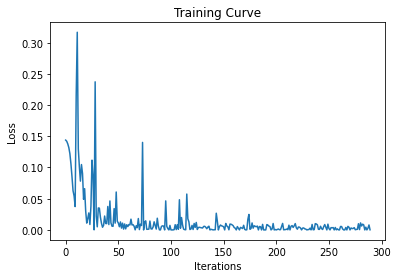

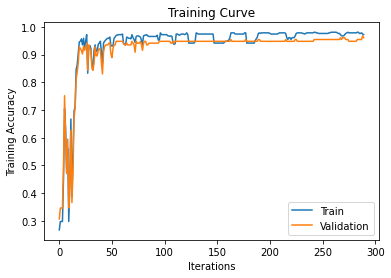

Final Training Accuracy: 0.9717391304347827
Final Validation Accuracy: 0.9607843137254902


In [ ]:
model = Classifier()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_loader, num_epochs=10)